<a href="https://colab.research.google.com/github/penguix0/container-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [1]:
!pip install tensorflow
!pip install pillow
!pip install tensorflow-datasets
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




```
# Dit is opgemaakt als code
```

tfds build --register_checksums

In [2]:
!bash
!cd container_dataset
!tfds build --register_checksums

bash: cannot set terminal process group (74): Inappropriate ioctl for device
bash: no job control in this shell
/content# cd container_dataset
/content/container_dataset# tfds build --register_checksums
INFO[build.py]: Loading dataset  from path: /content/container_dataset/container_dataset.py
2022-11-28 08:39:53.993830: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "NOT_FOUND: Error executing an HTTP request: HTTP response code 404".
INFO[build.py]: download_and_prepare for dataset container_dataset/1.0.0...
INFO[dataset_builder.py]: Generating dataset container_dataset (/root/tensorflow_datasets/container_dataset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

                                       


INFO[download_

## Import libraries

Import all libraries needed and configure the dataset and logging

In [3]:
## Import libaries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# Import the dataset
import container_dataset

# Setup logging
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


## Import and test the dataset

In [4]:
## Load the dataset
(train_dataset, val_dataset, test_dataset), metadata = tfds.load("container_dataset", 
    split=["train[:80%]", "train[80%:]", "test"], 
    with_info=True)

## Print classes which the program can detect
class_names = metadata.features["label"].names
print("Class names: {}".format(class_names))

## Print the number of examples in each set
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Class names: ['none', 'container_front']
Number of training examples: 81
Number of test examples:     10


## Extract all data from datset

In [15]:
IMG_WIDTH = 100

train_dataset_img = []
train_dataset_label = []
train_dataset_points = []
## Put img, label and points into array
for i in iter(train_dataset):
    # Add the image to the array
    img = i["image"]
    train_dataset_img.append(img)

    label = i["label"]
    train_dataset_label.append(label)

    points = i["points"]
    normalized_points = []
    for point in points:
      point /= IMG_WIDTH
      normalized_points.append(point)
    train_dataset_points.append(normalized_points)

## Convert to numpy array
train_dataset_img = np.array(train_dataset_img, dtype="float32")
train_dataset_label = np.array(train_dataset_label)
train_dataset_points = np.array(train_dataset_points)


test_dataset_img = []
test_dataset_label = []
test_dataset_points = []
## Put img, label and points into array
for i in iter(test_dataset):
    img = i["image"]
    test_dataset_img.append(img)

    label = i["label"]
    test_dataset_label.append(label)

    normalized_points = []
    for point in points:
      point /= IMG_WIDTH
      normalized_points.append(point)
    test_dataset_points.append(normalized_points)

## Convert to numpy array
test_dataset_img = np.array(test_dataset_img, dtype="float32")
test_dataset_label = np.array(test_dataset_label)
test_dataset_points = np.array(test_dataset_points)

val_dataset_img = []
val_dataset_label = []
val_dataset_points = []
## Put img, label and points into array
for i in iter(val_dataset):
    img = i["image"]
    val_dataset_img.append(img)
 
    label = i["label"]
    val_dataset_label.append(label)

    points = i["points"]
    normalized_points = []
    for point in points:
      point /= IMG_WIDTH
      normalized_points.append(point)
    val_dataset_points.append(normalized_points)
## Convert to numpy array
val_dataset_img = np.array(val_dataset_img, dtype="float32")
val_dataset_label = np.array(val_dataset_label)
val_dataset_points = np.array(val_dataset_points)

## Create the model input and base layers

In [16]:
IMG_WIDTH = 100 # pixels
IMG_HEIGHT = 100 # pixels
IMG_DEPTH = 3 # color channels

#create the common input layer
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)


## Create model classifier layers


In [17]:
#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(len(class_names), name='cl_head')(classifier_branch) 

## Create model locator branch

In [18]:
#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(8, activation='sigmoid', name='bb_head')(locator_branch)

## Create and compile a model

In [19]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])

Since the two output branches were designed to achieve two different outcomes (one to output a probability distribution and the other to predict the actual bounding box values), it was necessary to set the appropriate loss functions to each branch. I used the Sparse Categorical Crossentropy loss function for the classification head and the Mean Squared Error (MSE) for the localiser head. I achieved this by defining the following dictionary.

In [20]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [21]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 100, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 100, 100, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                            

## Train the model

In [22]:
trainTargets = {
    "cl_head": train_dataset_label,
    "bb_head": train_dataset_points
}
validationTargets = {
    "cl_head": val_dataset_label,
    "bb_head": val_dataset_points
}

EPOCHS = 17
history = model.fit(train_dataset_img, trainTargets,
             validation_data=(val_dataset_img, validationTargets),
             batch_size=4,
             epochs=EPOCHS,
             shuffle=True,
             verbose=1)

Epoch 1/17
17/17 [==============================] - 8s 31ms/step - loss: 0.1854 - cl_head_loss: 0.0379 - bb_head_loss: 0.1475 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.1231 - val_loss: 0.1327 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 0.1327 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.5625
Epoch 2/17
17/17 [==============================] - 0s 8ms/step - loss: 0.1264 - cl_head_loss: 1.8340e-08 - bb_head_loss: 0.1264 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.4308 - val_loss: 0.1398 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 0.1398 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.0000e+00
Epoch 3/17
17/17 [==============================] - 0s 7ms/step - loss: 0.1222 - cl_head_loss: 1.8340e-09 - bb_head_loss: 0.1222 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.3077 - val_loss: 0.1238 - val_cl_head_loss: 7.4506e-09 - val_bb_head_loss: 0.1238 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.5625
Epoch 4/17
17/17 [===============

## Plot model performance
Now that we've trained our model we are going to evaluate it on it's performance per epoch. We'll plot a graph using matplotlib.

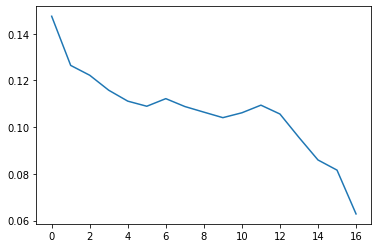

In [23]:
model_history = history.history
loss = model_history["loss"]
cl_head_loss = model_history["cl_head_loss"]
bb_head_loss = model_history["bb_head_loss"]
cl_head_accuracy = model_history["cl_head_accuracy"]
bb_head_accuracy = model_history["bb_head_accuracy"]
val_loss = model_history["val_loss"]
val_cl_head_loss = model_history["val_cl_head_loss"]
val_bb_head_loss = model_history["val_bb_head_loss"]
val_cl_head_accuracy = model_history["val_cl_head_accuracy"]
val_bb_head_accuracy = model_history["val_bb_head_accuracy"]

plt.plot(bb_head_loss)
plt.show()



In [33]:
from PIL import Image
print("Generate predictions for 3 samples")
data = train_dataset_img[:1]
predictions = model.predict(data)
img = Image.fromarray(data[0][:3][:3][0], 'RGB')
img.save('my.png')
img.show()

print (val_dataset_points[:1])
print (predictions)


Generate predictions for 3 samples
1/1 [==============================] - 0s 16ms/step
[[0.3523739  0.9851632  0.9681009  0.9035609  0.9681009  0.01335311
  0.3494065  0.00296736]]
[array([[-19.42699 ,  24.882475]], dtype=float32), array([[0.42197967, 0.23100412, 0.791676  , 0.9822317 , 0.87598056,
        0.876598  , 0.6174962 , 0.07155848]], dtype=float32)]
